Check CUDA

In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA devices:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())

Check pixel coord file

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

# Path to your folder containing images
image_folder = './objdet_input_data/objdet_input_images'

# Load the CSV file
csv_file = './objdet_input_data/merged_pixel_coordinates.csv'
df = pd.read_csv(csv_file)

# Select 20 random rows from the DataFrame
random_rows = df.sample(n=20, random_state=42)  # 'random_state' ensures reproducibility

# Loop through the randomly selected rows
for _, row in random_rows.iterrows():
    # Get image file name and bounding box coordinates
    image_name = row['image_name']
    x_min, y_min, x_max, y_max = int(row['x_min']), int(row['y_min']), int(row['x_max']), int(row['y_max'])
    
    # Load the image
    image_path = os.path.join(image_folder, image_name)
    image = cv2.imread(image_path)
    
    # Check if the image is loaded successfully
    if image is None:
        print(f"Error: Could not load image {image_name}")
        continue
    
    # Convert image from BGR (OpenCV format) to RGB (matplotlib format)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Draw the bounding box on the image
    cv2.rectangle(image_rgb, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)  # Red bounding box
    
    # Display the image with the bounding box
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis('off')  # Turn off axis
    plt.title(image_name)
    plt.show()


In [1]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow.keras.backend as K

# Paths to data
image_dir = "../1_DatasetCharacteristics/seamounts_seg_cropped"
csv_path = "../1_DatasetCharacteristics/merged_pixel_coordinates.csv"

# Constants
IMAGE_SIZE = (256, 256)  # Reduced image size to 128x128
BATCH_SIZE = 16  # Reduced batch size to 8
EPOCHS = 40

# Load bounding box data
bbox_data = pd.read_csv(csv_path)

# Function to load images
def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Load in color (BGR format)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image

# Function to preprocess bounding boxes
def preprocess_bboxes(row, original_size, resized_size):
    x_min, y_min, x_max, y_max = row[['x_min', 'y_min', 'x_max', 'y_max']]
    orig_height, orig_width = original_size
    resized_height, resized_width = resized_size

    if x_min == -1 and y_min == -1 and x_max == -1 and y_max == -1:
        return [-1, -1, -1, -1]  # No object case

    # Scale the bounding box coordinates according to the resizing ratio
    x_min = x_min * (resized_width / orig_width)
    y_min = y_min * (resized_height / orig_height)
    x_max = x_max * (resized_width / orig_width)
    y_max = y_max * (resized_height / orig_height)

    # Normalize coordinates to [0, 1]
    x_min /= resized_width
    y_min /= resized_height
    x_max /= resized_width
    y_max /= resized_height

    return [x_min, y_min, x_max, y_max]

# Prepare dataset
image_paths = []
bboxes = []
has_objects = []
for _, row in bbox_data.iterrows():
    img_path = os.path.join(image_dir, row['image_name'])
    if os.path.exists(img_path):
        # Load image without resizing to get original dimensions
        original_image = load_image(img_path)
        original_size = (original_image.shape[0], original_image.shape[1])

        # Preprocess bounding box
        bbox = preprocess_bboxes(row, original_size, IMAGE_SIZE)
        bboxes.append(bbox)

        # Add object presence label
        has_objects.append(0 if bbox == [-1, -1, -1, -1] else 1)

        # Resize the image
        image_paths.append(img_path)

# Convert to numpy arrays
bboxes = np.array(bboxes)
has_objects = np.array(has_objects)

# Split data
X_train_paths, X_val_paths, y_train_bboxes, y_val_bboxes, y_train_class, y_val_class = train_test_split(
    image_paths, bboxes, has_objects, test_size=0.2, random_state=42
)

# Define Huber loss
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= delta
    small_error_loss = 0.5 * tf.square(error)
    large_error_loss = delta * (tf.abs(error) - 0.5 * delta)
    return tf.where(is_small_error, small_error_loss, large_error_loss)

# Custom data generator
class ImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, bboxes, has_objects, batch_size, image_size, shuffle=True):
        self.image_paths = image_paths
        self.bboxes = bboxes
        self.has_objects = has_objects
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.image_paths))
        
    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        batch_image_paths = [self.image_paths[i] for i in batch_indices]
        batch_bboxes = [self.bboxes[i] for i in batch_indices]
        batch_has_objects = [self.has_objects[i] for i in batch_indices]
        
        # Load and preprocess batch images
        images = np.array([self.load_image(image_path) for image_path in batch_image_paths])
        bboxes = np.array(batch_bboxes)
        has_objects = np.array(batch_has_objects)
        
        return images, {'class_output': has_objects, 'bbox_output': bboxes}
    
    def load_image(self, image_path):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.image_size)  # Resize image to fixed size
        image = image / 255.0  # Normalize
        return image

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# Modify model to accept hyperparameters from Keras Tuner
def create_model_with_hyperparameters(hp):
    inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    
    # Shared convolutional base
    x = layers.Conv2D(
        hp.Int('conv1_filters', min_value=32, max_value=64, step=32),  # Reduced filter range
        (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(
        hp.Int('conv2_filters', min_value=64, max_value=128, step=64),  # Reduced filter range
        (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(
        hp.Int('conv3_filters', min_value=128, max_value=256, step=128),  # Reduced filter range
        (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Flatten()(x)
    
    # Fully connected layers with smaller units
    x = layers.Dense(
        hp.Int('dense1_units', min_value=256, max_value=1024, step=256),  # Reduced units range
        activation='relu')(x)
    x = layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x)
    
    x = layers.Dense(
        hp.Int('dense2_units', min_value=128, max_value=512, step=128),  # Reduced units range
        activation='relu')(x)
    x = layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x)
    
    # Output layers
    class_output = layers.Dense(1, activation='sigmoid', name='class_output')(x)
    bbox_output = layers.Dense(4, activation='linear', name='bbox_output')(x)
    
    model = models.Model(inputs, [class_output, bbox_output])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG', default=1e-3)
        ),
        loss={
            'class_output': 'binary_crossentropy',
            'bbox_output': huber_loss
        },
        loss_weights={
            'class_output': 1.0,
            'bbox_output': 1.0
        },
        metrics={
            'class_output': ['accuracy'],
            'bbox_output': ['mae']
        }
    )
    
    return model

# Hyperparameter search with reduced complexity
def tune_model():
    tuner = kt.Hyperband(
        create_model_with_hyperparameters, 
        objective='val_loss',
        max_epochs=40,  # Fewer epochs
        hyperband_iterations=1,  # Fewer iterations
        directory='tuning_results',
        project_name='seamount_detection',
        overwrite=True  # Overwrite existing files
    )

    tuner.search(
        train_generator,
        validation_data=val_generator,
        epochs=40,  # Fewer epochs
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]  # Early stopping
    )
    
    # Get the best model and hyperparameters
    best_model = tuner.get_best_models(1)[0]
    best_hyperparameters = tuner.oracle.get_best_trials(1)[0].hyperparameters
    print("Best hyperparameters:", best_hyperparameters.values)
    
    return best_model

# Training and validation data generators
train_generator = ImageDataGenerator(X_train_paths, y_train_bboxes, y_train_class, BATCH_SIZE, IMAGE_SIZE)
val_generator = ImageDataGenerator(X_val_paths, y_val_bboxes, y_val_class, BATCH_SIZE, IMAGE_SIZE)

# Tune the model
best_model = tune_model()

# Train the model
best_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

# Clear session to release memory after training
K.clear_session()


Trial 90 Complete [00h 01m 43s]
val_loss: 0.3290186822414398

Best val_loss So Far: 0.24369417130947113
Total elapsed time: 02h 12m 06s
Best hyperparameters: {'conv1_filters': 64, 'conv2_filters': 128, 'conv3_filters': 128, 'dense1_units': 1024, 'dropout_rate': 0.2, 'dense2_units': 128, 'learning_rate': 0.00014763284782764668, 'tuner/epochs': 40, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Epoch 1/40
148/148 [==============================] - 15s 96ms/step - loss: 0.0774 - class_output_loss: 0.0337 - bbox_output_loss: 0.0437 - class_output_accuracy: 0.9941 - bbox_output_mae: 0.2250 - val_loss: 0.2542 - val_class_output_loss: 0.1959 - val_bbox_output_loss: 0.0584 - val_class_output_accuracy: 0.9493 - val_bbox_output_mae: 0.2012
Epoch 2/40
148/148 [==============================] - 14s 94ms/step - loss: 0.0551 - class_output_loss: 0.0196 - bbox_output_loss: 0.0355 - class_output_accuracy: 0.9983 - bbox_output_mae: 0.2039 - val_loss: 0.2644 - val_class_output_loss: 0.2

## Using the found values on the 1_1 model:

Epoch 1/20
149/149 [==============================] - 42s 154ms/step - loss: 0.5928 - class_output_loss: 0.4298 - bbox_output_loss: 0.1630 - class_output_accuracy: 0.8321 - bbox_output_mae: 0.4260 - val_loss: 0.5000 - val_class_output_loss: 0.3566 - val_bbox_output_loss: 0.1434 - val_class_output_accuracy: 0.8389 - val_bbox_output_mae: 0.3444
Epoch 2/20
149/149 [==============================] - 17s 115ms/step - loss: 0.4389 - class_output_loss: 0.2937 - bbox_output_loss: 0.1451 - class_output_accuracy: 0.8619 - bbox_output_mae: 0.4151 - val_loss: 0.3431 - val_class_output_loss: 0.2397 - val_bbox_output_loss: 0.1034 - val_class_output_accuracy: 0.9195 - val_bbox_output_mae: 0.3259
Epoch 3/20
149/149 [==============================] - 16s 107ms/step - loss: 0.3416 - class_output_loss: 0.2250 - bbox_output_loss: 0.1166 - class_output_accuracy: 0.9219 - bbox_output_mae: 0.3736 - val_loss: 0.2912 - val_class_output_loss: 0.2126 - val_bbox_output_loss: 0.0786 - val_class_output_accuracy: 0.

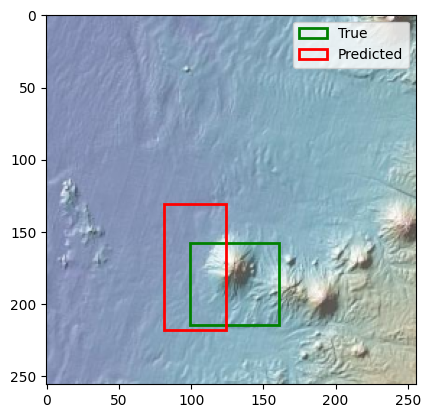

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


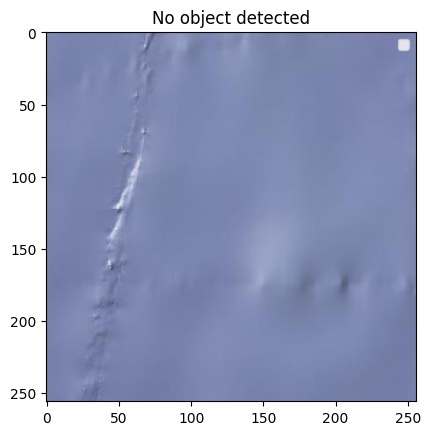

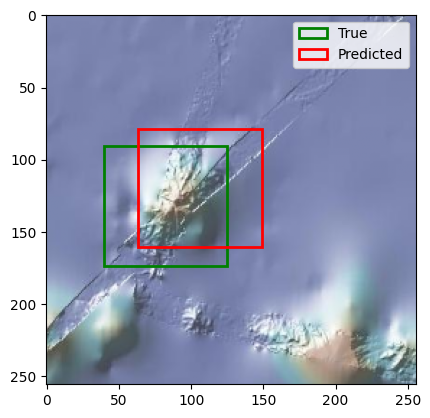

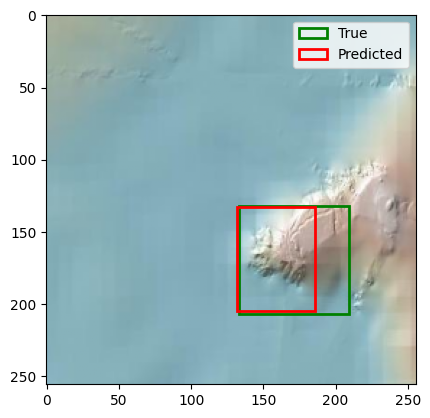

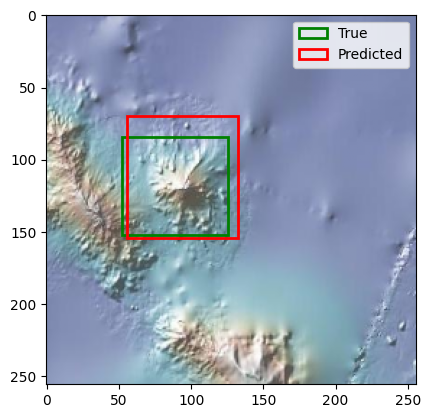

In [1]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Paths to data
image_dir = "./objdet_input_data/objdet_input_images"
csv_path = "./objdet_input_data/merged_pixel_coordinates.csv"

# Constants
IMAGE_SIZE = (256, 256)  # Resize images to 256x256 (as per the original code)
BATCH_SIZE = 16
EPOCHS = 20  # Adjusted to 40 from Keras tuner results

# Hyperparameters from Keras Tuner results
conv1_filters = 64
conv2_filters = 128
conv3_filters = 128
dense1_units = 1024
dropout_rate = 0.2
dense2_units = 128
learning_rate = 0.00014763284782764668

# Load bounding box data
bbox_data = pd.read_csv(csv_path)

# Function to load images
def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Load in color (BGR format)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image

# Function to preprocess bounding boxes
def preprocess_bboxes(row, original_size, resized_size):
    x_min, y_min, x_max, y_max = row[['x_min', 'y_min', 'x_max', 'y_max']]
    orig_height, orig_width = original_size
    resized_height, resized_width = resized_size

    if x_min == -1 and y_min == -1 and x_max == -1 and y_max == -1:
        return [-1, -1, -1, -1]  # No object case

    # Scale the bounding box coordinates according to the resizing ratio
    x_min = x_min * (resized_width / orig_width)
    y_min = y_min * (resized_height / orig_height)
    x_max = x_max * (resized_width / orig_width)
    y_max = y_max * (resized_height / orig_height)

    # Normalize coordinates to [0, 1]
    x_min /= resized_width
    y_min /= resized_height
    x_max /= resized_width
    y_max /= resized_height

    return [x_min, y_min, x_max, y_max]

# Prepare dataset
images = []
bboxes = []
has_objects = []
for _, row in bbox_data.iterrows():
    img_path = os.path.join(image_dir, row['image_name'])
    if os.path.exists(img_path):
        # Load image without resizing to get original dimensions
        original_image = load_image(img_path)
        original_size = (original_image.shape[0], original_image.shape[1])

        # Preprocess bounding box
        bbox = preprocess_bboxes(row, original_size, IMAGE_SIZE)
        bboxes.append(bbox)

        # Add object presence label
        has_objects.append(0 if bbox == [-1, -1, -1, -1] else 1)

        # Resize the image
        resized_image = cv2.resize(original_image, IMAGE_SIZE)
        images.append(resized_image)

images = np.array(images)
bboxes = np.array(bboxes)
has_objects = np.array(has_objects)

# Split data
X_train, X_val, y_train_bboxes, y_val_bboxes, y_train_class, y_val_class = train_test_split(
    images, bboxes, has_objects, test_size=0.2, random_state=42
)

# Define Huber loss
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= delta
    small_error_loss = 0.5 * tf.square(error)
    large_error_loss = delta * (tf.abs(error) - 0.5 * delta)
    return tf.where(is_small_error, small_error_loss, large_error_loss)

# Custom combined loss function
def custom_loss(y_true, y_pred):
    class_true, bbox_true = y_true
    class_pred, bbox_pred = y_pred
    
    # Binary cross-entropy for classification
    class_loss = tf.keras.losses.binary_crossentropy(class_true, class_pred)
    
    # Huber loss for bounding box regression (only for positive class)
    bbox_loss = huber_loss(bbox_true, bbox_pred)
    bbox_loss = tf.where(class_true == 1, bbox_loss, 0.0)
    
    return class_loss + bbox_loss

# Define the model architecture
def create_model_with_no_object_detection():
    inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    
    # Shared convolutional base
    x = layers.Conv2D(conv1_filters, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(conv2_filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(conv3_filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Additional layers for optimization
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    
    # Fully connected layers
    x = layers.Dense(dense1_units, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(dense2_units, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    
    # Classification branch
    class_output = layers.Dense(1, activation='sigmoid', name='class_output')(x)
    
    # Bounding box regression branch
    bbox_output = layers.Dense(4, activation='linear', name='bbox_output')(x)
    
    model = models.Model(inputs, [class_output, bbox_output])
    return model

# Compile the model with the Adam optimizer and a learning rate from Keras Tuner result
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Create and compile the model
model = create_model_with_no_object_detection()
model.compile(
    optimizer=optimizer,
    loss={
        'class_output': 'binary_crossentropy',
        'bbox_output': huber_loss
    },
    loss_weights={
        'class_output': 1.0,
        'bbox_output': 1.0
    },
    metrics={
        'class_output': ['accuracy'],
        'bbox_output': ['mae']
    }
)

# Train the model
history = model.fit(
    X_train, {'class_output': y_train_class, 'bbox_output': y_train_bboxes},
    validation_data=(X_val, {'class_output': y_val_class, 'bbox_output': y_val_bboxes}),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Save the trained model (optional)
model_save_path = "objdet_with_no_object_model.h5"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

# Evaluate the model
val_loss = model.evaluate(
    X_val, {'class_output': y_val_class, 'bbox_output': y_val_bboxes}
)
print(f"Validation Loss: {val_loss}")

# Visualization of predictions
def plot_predictions_with_no_object(images, true_bboxes, pred_bboxes, true_classes, pred_classes):
    for i in range(5):  # Show 5 examples
        img = images[i]
        true_bbox = true_bboxes[i]
        pred_bbox = pred_bboxes[i]
        true_class = true_classes[i]
        pred_class = pred_classes[i]

        plt.imshow(img)
        if pred_class < 0.5:  # No object detected
            plt.title("No object detected")
        else:
            h, w, _ = img.shape
            true_rect = [
                true_bbox[0] * w, true_bbox[1] * h,
                (true_bbox[2] - true_bbox[0]) * w, (true_bbox[3] - true_bbox[1]) * h
            ]
            plt.gca().add_patch(plt.Rectangle(
                (true_rect[0], true_rect[1]),
                true_rect[2], true_rect[3],
                edgecolor='green', facecolor='none', lw=2, label='True'
            ))
            pred_rect = [
                pred_bbox[0] * w, pred_bbox[1] * h,
                (pred_bbox[2] - pred_bbox[0]) * w, (pred_bbox[3] - pred_bbox[1]) * h
            ]
            plt.gca().add_patch(plt.Rectangle(
                (pred_rect[0], pred_rect[1]),
                pred_rect[2], pred_rect[3],
                edgecolor='red', facecolor='none', lw=2, label='Predicted'
            ))
        plt.legend()
        plt.show()

# Make predictions
pred_classes, pred_bboxes = model.predict(X_val)
plot_predictions_with_no_object(X_val, y_val_bboxes, pred_bboxes, y_val_class, pred_classes)


## More Evaluation Data

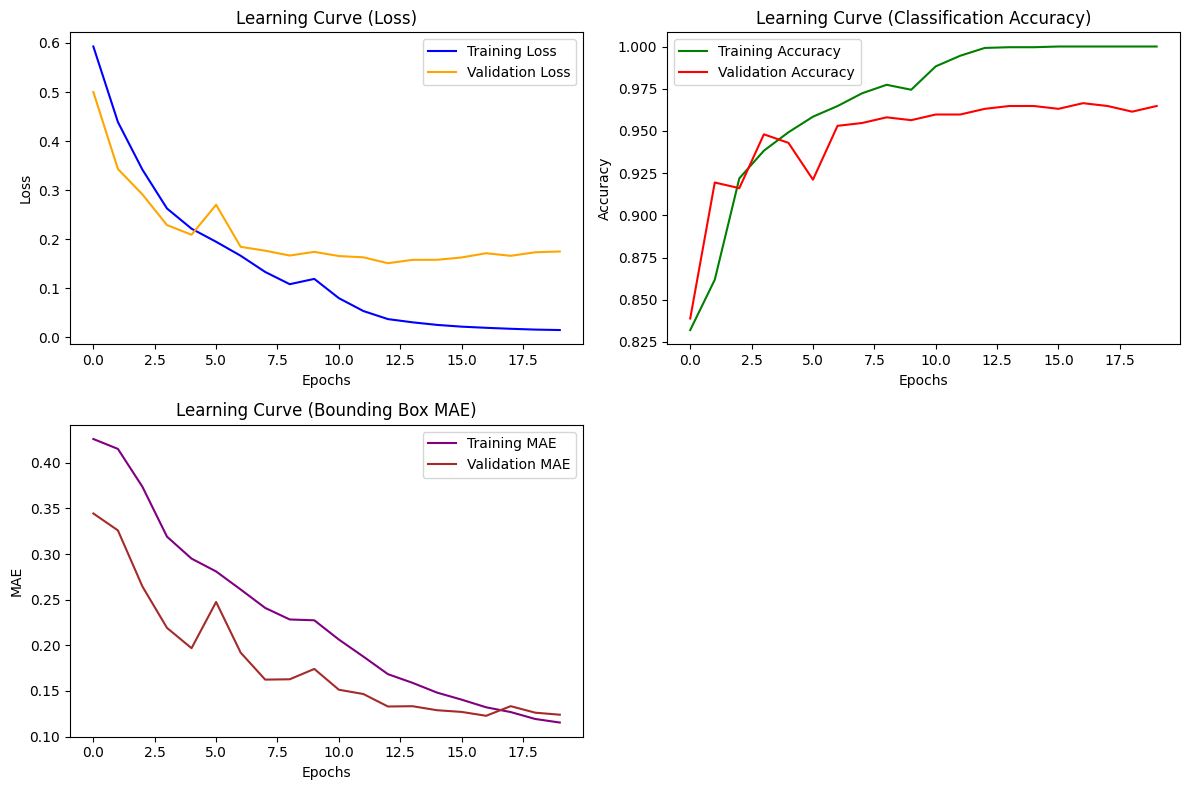

Average IoU on Validation Set (excluding true no-object cases): 0.4497


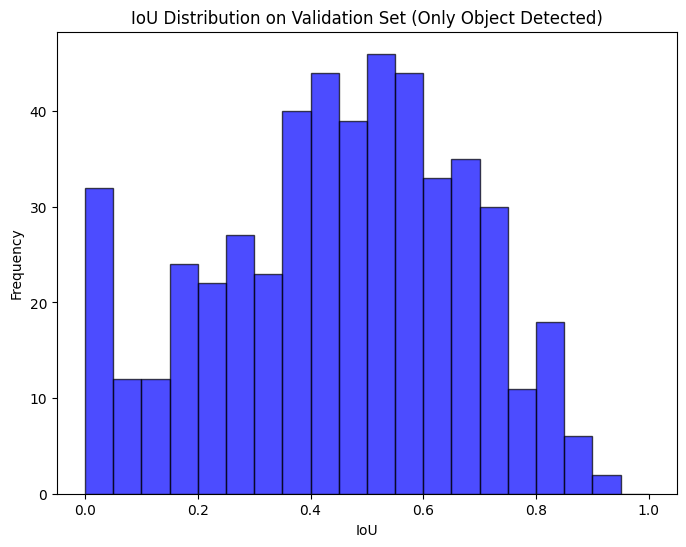

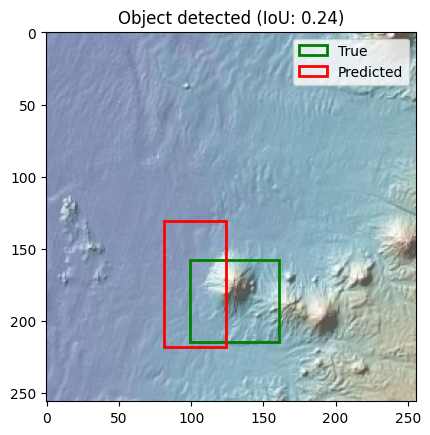

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


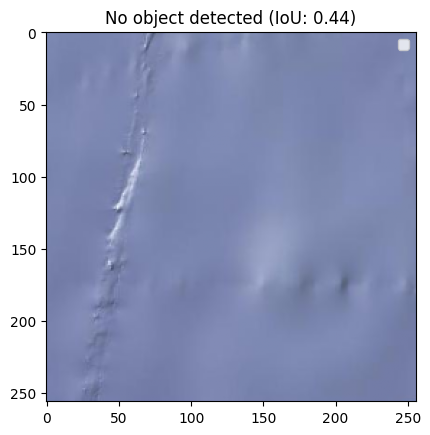

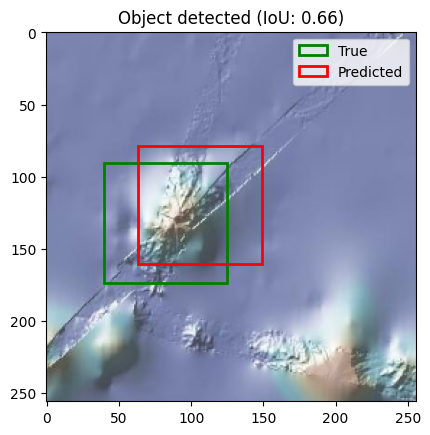

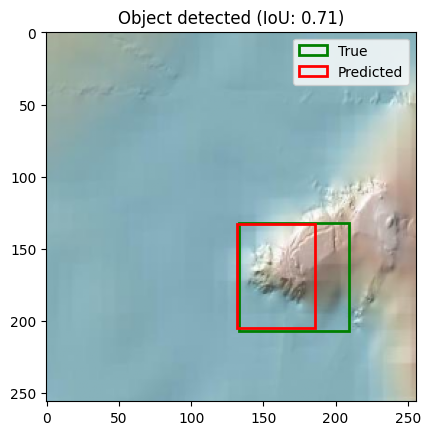

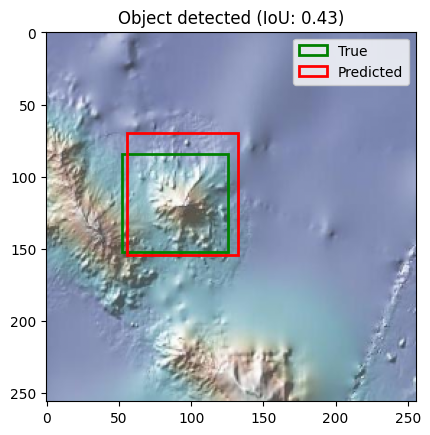

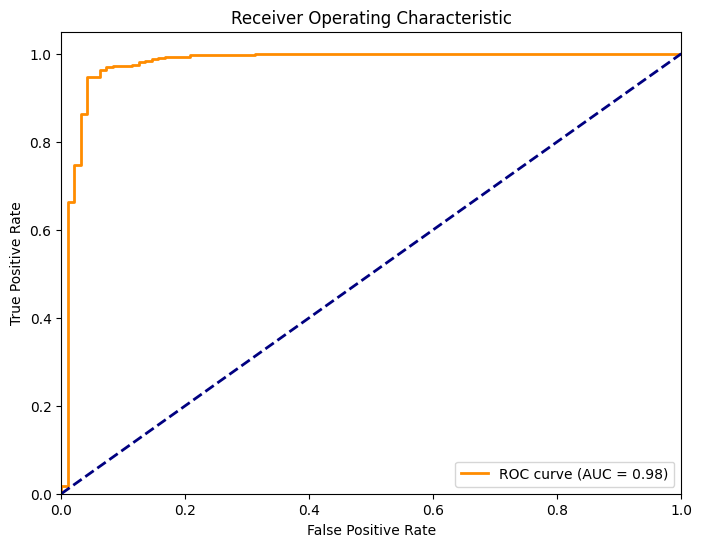

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.89        96
           1       0.97      0.99      0.98       500

    accuracy                           0.96       596
   macro avg       0.95      0.92      0.93       596
weighted avg       0.96      0.96      0.96       596



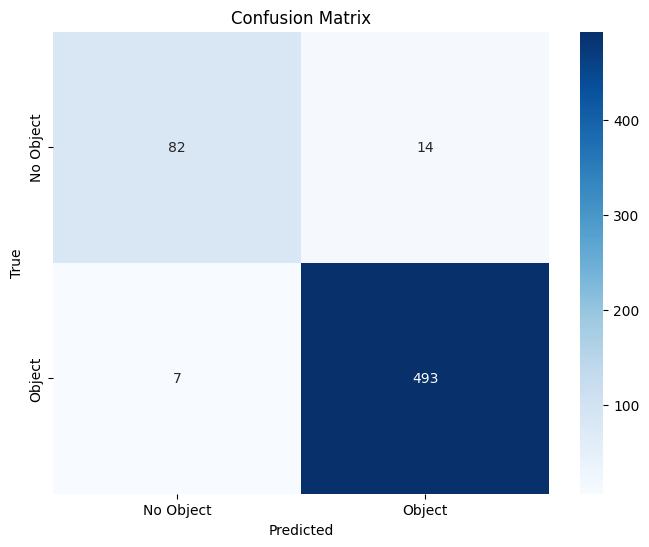

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

# Plot the learning curve (Training & Validation Loss, Accuracy, and MAE)
def plot_learning_curves(history):
    # Extract the loss values from history
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Extract the accuracy and MAE values from history (for classification and bbox prediction)
    class_accuracy = history.history['class_output_accuracy']
    val_class_accuracy = history.history['val_class_output_accuracy']
    
    bbox_mae = history.history['bbox_output_mae']
    val_bbox_mae = history.history['val_bbox_output_mae']
    
    # Plot the loss curve
    plt.figure(figsize=(12, 8))

    # Plot Loss Curve
    plt.subplot(2, 2, 1)
    plt.plot(loss, label='Training Loss', color='blue')
    plt.plot(val_loss, label='Validation Loss', color='orange')
    plt.title("Learning Curve (Loss)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy Curve for Classification
    plt.subplot(2, 2, 2)
    plt.plot(class_accuracy, label='Training Accuracy', color='green')
    plt.plot(val_class_accuracy, label='Validation Accuracy', color='red')
    plt.title("Learning Curve (Classification Accuracy)")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot MAE Curve for Bounding Box Regression
    plt.subplot(2, 2, 3)
    plt.plot(bbox_mae, label='Training MAE', color='purple')
    plt.plot(val_bbox_mae, label='Validation MAE', color='brown')
    plt.title("Learning Curve (Bounding Box MAE)")
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.legend()

    # Show all plots
    plt.tight_layout()
    plt.show()

# Function to calculate IoU (Intersection over Union) excluding true no-object cases
def calculate_iou(true_bbox, pred_bbox, true_class, pred_class):
    # Exclude IoU calculation if the true class has no object (true_class < 0.5)
    if true_class < 0.5:  # True class has no object, so exclude IoU calculation
        return None  # Skip IoU calculation for true no-object cases

    x_min_true, y_min_true, x_max_true, y_max_true = true_bbox
    x_min_pred, y_min_pred, x_max_pred, y_max_pred = pred_bbox

    # Calculate intersection
    inter_x_min = max(x_min_true, x_min_pred)
    inter_y_min = max(y_min_true, y_min_pred)
    inter_x_max = min(x_max_true, x_max_pred)
    inter_y_max = min(y_max_true, y_max_pred)

    inter_width = max(0, inter_x_max - inter_x_min)
    inter_height = max(0, inter_y_max - inter_y_min)
    intersection = inter_width * inter_height

    # Calculate union
    true_area = (x_max_true - x_min_true) * (y_max_true - y_min_true)
    pred_area = (x_max_pred - x_min_pred) * (y_max_pred - y_min_pred)
    union = true_area + pred_area - intersection

    return intersection / union if union > 0 else 0.0

# Function to evaluate IoU for validation set (excluding true no-object cases)
def evaluate_iou(y_val_bboxes, pred_bboxes, y_val_class, pred_classes):
    ious = []
    for i in range(len(y_val_bboxes)):
        iou = calculate_iou(y_val_bboxes[i], pred_bboxes[i], y_val_class[i], pred_classes[i])
        if iou is not None:  # Only append IoU values for valid cases
            ious.append(iou)

    average_iou = np.mean(ious)
    print(f"Average IoU on Validation Set (excluding true no-object cases): {average_iou:.4f}")

    return ious

# Function to plot IoU distribution (excluding true no-object cases)
def plot_iou_distribution(ious):
    plt.figure(figsize=(8, 6))
    plt.hist(ious, bins=20, range=(0, 1), color='blue', alpha=0.7, edgecolor='black')
    plt.title("IoU Distribution on Validation Set (Only Object Detected)")
    plt.xlabel("IoU")
    plt.ylabel("Frequency")
    plt.show()

# Function to plot predictions with IoU
def plot_predictions_with_iou(images, true_bboxes, pred_bboxes, true_classes, pred_classes, ious, num_examples=5):
    for i in range(num_examples):
        img = images[i]
        true_bbox = true_bboxes[i]
        pred_bbox = pred_bboxes[i]
        true_class = true_classes[i]
        pred_class = pred_classes[i]
        iou = ious[i]

        plt.imshow(img)
        if pred_class < 0.5:  # No object detected by model
            plt.title(f"No object detected (IoU: {iou:.2f})")
        else:
            h, w, _ = img.shape
            true_rect = [
                true_bbox[0] * w, true_bbox[1] * h,
                (true_bbox[2] - true_bbox[0]) * w, (true_bbox[3] - true_bbox[1]) * h
            ]
            plt.gca().add_patch(plt.Rectangle(
                (true_rect[0], true_rect[1]),
                true_rect[2], true_rect[3],
                edgecolor='green', facecolor='none', lw=2, label='True'
            ))
            pred_rect = [
                pred_bbox[0] * w, pred_bbox[1] * h,
                (pred_bbox[2] - pred_bbox[0]) * w, (pred_bbox[3] - pred_bbox[1]) * h
            ]
            plt.gca().add_patch(plt.Rectangle(
                (pred_rect[0], pred_rect[1]),
                pred_rect[2], pred_rect[3],
                edgecolor='red', facecolor='none', lw=2, label='Predicted'
            ))
            plt.title(f"Object detected (IoU: {iou:.2f})")
        plt.legend()
        plt.show()

# Function to plot ROC Curve
def plot_roc_curve(true_classes, pred_classes):
    # Get the ROC curve data (use the raw predicted probabilities for the ROC curve)
    fpr, tpr, thresholds = roc_curve(true_classes, pred_classes)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(true_classes, pred_classes):
    cm = confusion_matrix(true_classes, pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Object', 'Object'], yticklabels=['No Object', 'Object'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Function to print classification report (precision, recall, f1-score, support)
def print_classification_report(true_classes, pred_classes):
    report = classification_report(true_classes, pred_classes)
    print("Classification Report:")
    print(report)

# Assuming you have your model's history and prediction results
# Example usage:

plot_learning_curves(history)  # Plot training/validation learning curves

# Assuming you have the following data available:
# y_val_bboxes: Ground truth bounding boxes for validation set
# pred_bboxes: Predicted bounding boxes by the model
# y_val_class: Ground truth class labels for validation set
# pred_classes: Predicted class probabilities by the model
# X_val: Validation images

# Calculate and evaluate IoU
ious = evaluate_iou(y_val_bboxes, pred_bboxes, y_val_class, pred_classes)  # Calculate IoU values

# Plot the IoU distribution (excluding true no-object cases)
plot_iou_distribution(ious)  # Plot the distribution of IoU values

# Visualize predictions with IoU
plot_predictions_with_iou(X_val, y_val_bboxes, pred_bboxes, y_val_class, pred_classes, ious)  # Visualize predictions with IoU

# Assuming you have true_classes (ground truth labels) and pred_classes (model predictions)

# Convert continuous probabilities to binary labels for classification metrics
pred_class_labels = (pred_classes >= 0.5).astype(int)  # Convert probabilities to 0 or 1

# Plot the ROC curve using raw probabilities
plot_roc_curve(y_val_class, pred_classes)  # true labels vs. predicted probabilities

# Print the classification report using binary labels
print_classification_report(y_val_class, pred_class_labels)  # true labels vs. predicted binary labels

# Plot the confusion matrix using binary labels
plot_confusion_matrix(y_val_class, pred_class_labels)  # true labels vs. predicted binary labels


## Test on unseen unlabeled data

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Path to the new data (unlabeled)
unlabeled_image_dir = "../1_DatasetCharacteristics/seamount_images_equal_tiles_cropped"

# Function to load images (same as in training)
def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Load in color (BGR format)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image

# Function to plot predictions (same as before)
def plot_predictions_with_no_object(images, pred_bboxes, pred_classes):
    for i in range(20):  # Show 5 examples
        img = images[i]
        pred_bbox = pred_bboxes[i]
        pred_class = pred_classes[i]

        plt.imshow(img)
        if pred_class < 0.5:  # No object detected
            plt.title("No object detected")
        else:
            h, w, _ = img.shape
            pred_rect = [
                pred_bbox[0] * w, pred_bbox[1] * h,
                (pred_bbox[2] - pred_bbox[0]) * w, (pred_bbox[3] - pred_bbox[1]) * h
            ]
            plt.gca().add_patch(plt.Rectangle(
                (pred_rect[0], pred_rect[1]),
                pred_rect[2], pred_rect[3],
                edgecolor='red', facecolor='none', lw=2, label='Predicted'
            ))
        plt.legend()
        plt.show()

# Load the trained model (if not already loaded)
# If you already have the model loaded, you can skip this step.
# model = load_model('objdet_with_no_object_model.h5', custom_objects={'huber_loss': huber_loss})

# Load and preprocess unseen images
unlabeled_images = []
for image_name in os.listdir(unlabeled_image_dir):
    img_path = os.path.join(unlabeled_image_dir, image_name)
    if os.path.exists(img_path):
        img = load_image(img_path)
        resized_img = cv2.resize(img, IMAGE_SIZE)  # Resize images to match the model input size
        unlabeled_images.append(resized_img)

unlabeled_images = np.array(unlabeled_images)

# Make predictions on the unseen data
pred_classes, pred_bboxes = model.predict(unlabeled_images)

# Visualize the predictions
plot_predictions_with_no_object(unlabeled_images, pred_bboxes, pred_classes)


NameError: name 'model' is not defined